<a href="https://colab.research.google.com/github/eshghinezhad/ML_Classifire_Student_Success/blob/master/Student_Success_Classifires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Assignment 2- Building Classifiers** ---------- **Monireh Eshghinezhad**
> #

In [ ]:
import numpy as np
import pandas as pd

##  **Data Loading and Initial Cleaning** (Brief EDA)

In [ ]:
student=pd.read_csv("MAI101 W26 A1 data v0.1.csv")

Base on the assignment1, the dataset contains 1,677 **rows** and 17 **columns**.
Several variables contain **missing** values.
The Business101Grade variable includes values **outside** the expected **range** (>100).
The status variable contains **invalid categories** ('S', 'X', 'V2'). Some column names contain spaces.

####Before proceeding with modeling, basic data cleaning was performed:

1.   Renamed columns to remove spaces.
2.   Kept only valid status values ('D', 'I').
3.   Removed records where Business101Grade exceeded 100.
4.   Removed records where has missing in OverallAverageGrade.
4.   Reset the index after filtering.

## **Structural Fix:**

In [ ]:
#assign the appropriate name for some features
student = student.rename(columns={
 "Math101 Grade": "Math101Grade",
 "Business101 Grade": "Business101Grade",
 "Overall Average Grade": "OverallAverageGrade"
})
# keeps only valid status.
valid_status = ['D', 'I']
student = student[student['status'].isin(valid_status)]
# keeps only valid Business101Grade
student = student[student['Business101Grade'] <= 100 ]

student = student.dropna(subset=['OverallAverageGrade'])
# creates a new index & Do not keep the old index as a separate column.
student = student.reset_index(drop=True)

## **Create the Target Variable**:
### Create the new column '**on_schedule**' (1 or 0) base on '**duration**' and '**totalSemesters**'

In [ ]:
student['onSchedule'] = ((student.hasGraduated == 1) &
(student.totalSemesters <= (student.duration * 2 + 2))).astype(int)

## **Analyze Target Variable:**
 >##  **A- Class Balance**

In [ ]:
# Show the number and proportion of each class in target variable.
print(student.onSchedule.value_counts())
print("-"*50)
print (student["onSchedule"].value_counts(normalize=True))   #show the percentage of each value

onSchedule
0    1036
1     617
Name: count, dtype: int64
--------------------------------------------------
onSchedule
0    0.626739
1    0.373261
Name: proportion, dtype: float64


### The target variable shows a **moderate class imbalance**. Approximately 63% of students did not graduate on schedule, while 37% graduated on schedule.
> ### Because of this imbalance, evaluation metrics beyond overall accuracy, such as **precision**, **recall**, and **F1-score**, will be considered to properly **assess model performance**.

>## **B- Class Relationships**

In [ ]:
 # Show the relationship between the target variable and other features
display(student.groupby("onSchedule")["OverallAverageGrade"].mean())
display(pd.crosstab(student["status"], student["onSchedule"]))
display(pd.crosstab(student["gender"], student["onSchedule"]))
display(pd.crosstab(student["transfer_in"], student["onSchedule"]))
display(pd.crosstab(student["Mature"], student["onSchedule"]))

,OverallAverageGrade
onSchedule,
0,67.727896
1,79.663533


onSchedule,0,1
status,,
D,779,455
I,257,162


onSchedule,0,1
gender,,
F,366,249
M,670,368


onSchedule,0,1
transfer_in,,
0,734,329
1,302,288


onSchedule,0,1
Mature,,
0,540,235
1,496,382


> # **Feature and Target Separation** ??? duration ??

In [ ]:
numerical_features = ['duration', 'LangTestPercent','MathTestPercent',
                      'AptitudeTestPercent', 'transfer_in', 'Business101Grade',
                      'Mature']
categorical_features = ['program', 'status', 'gender', 'Math101Grade']

x = student[numerical_features + categorical_features]
y = student["onSchedule"]

## **Split dataset** into **Training(60%)**, **Validation(20%)** and **Test(20%)** sets
#####The data was split using a fixed random state for reproducibility and stratification to preserve the class distribution in both training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Split into (Train + Val)(80%) and Test(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y
)

# 2. Split (Train + Val) into separate Train(60%) and Validation(20%) sets      stratify=y: keeps the class distribution consistent.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val
)

###  **Variable Issues & Steps Report**

| Variable Name    |	Issue Identified	       |  Step/Transformation Applied    |
|------------------|--------------------------|---------------------------------|
| onSchedule       | Not explicitly in dataset|Create the new column,using hasGraduated and totalSemesters columns.
| Numeric Features | Missing values, different scales|Imputed using median strategy, then standardized (Z-score scaling)|
|Categorical Features| Text values need numeric representation|One-Hot Encoding applied to convert categories to binary features|

####To prevent data leakage, all **imputation** and **scaling** parameters were derived exclusively from the training data (X_train and y_train) and then applied using a **ColumnTransformer** within the **pipelines**.
###Also applied stratification during the train, validation, and test split to maintain the class distribution ratio (63% / 37%) across all three sets.

> ## Build the **ColumnTransformer** and **Pipeline**
Apply different transformations to different columns.
| Column Type   | Transformation       |
|---------------|----------------------|
| Numeric       |  **Median** + **Scaling**    |
| Categorical   |  OneHotEncode        |

In [ ]:
# we have mixed columns(numeric + categorical). we need apply different transformations to different columns.
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 1. Define the pipelines for each type of feature
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Fills missing with median
    ('scaler', StandardScaler())                    # Scales the numericals for distance-based algorithms (KNN, SVM) is required.
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

# 2. Combine them into one ColumnTransformer
full_prep = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# **1- K Neighbors Classifier**


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
# Builds a model structure.-> n_neighbors = 5 (default value)
baseline_knn = make_pipeline(full_prep, KNeighborsClassifier())
baseline_knn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

## **A- Train and Evaluate Performance**
> - ### **Evaluate Baseline Model**

In [70]:
# Baseline KNN (default parameters)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

baseline_knn = make_pipeline(full_prep, KNeighborsClassifier())

baseline_knn.fit(X_train, y_train)

y_val_pred_baseline = baseline_knn.predict(X_val)

print("BASELINE K Neighbors Model:")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred_baseline):.2f}")
print("Validation F1:", f"{f1_score(y_val, y_val_pred_baseline):.2f}")
print("\n Confusion Matrix: \n",confusion_matrix(y_val, y_val_pred_baseline))
print("\n Classification Report:\n", classification_report(y_val, y_val_pred_baseline, target_names=['0-not onSchedule', '1-onSchedule']))

BASELINE K Neighbors Model:
Validation Accuracy: 0.65
Validation F1: 0.50

 Confusion Matrix: 
 [[157  51]
 [ 65  58]]

 Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.71      0.75      0.73       208
    1-onSchedule       0.53      0.47      0.50       123

        accuracy                           0.65       331
       macro avg       0.62      0.61      0.62       331
    weighted avg       0.64      0.65      0.64       331



> ### The baseline KNN model exhibits a tendency to **misclassify the minority class** ('onSchedule'), leading to a significant number of **false negatives**. This highlights the **need for hyperparameter tuning** and potentially strategies to address class imbalance to improve the model's ability to correctly identify students on schedule.

  > - ### **Analize the model** - 4 difrent numbers of Neighbors

In [ ]:
for k in [1, 15,25, 50]:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train)

    y_train_pred = knn_model.predict(X_train)
    y_validation_pred = knn_model.predict(X_val)

    print(f"k = {k}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.2f}")
    print(f"Validation Accuracy : {accuracy_score(y_val, y_validation_pred):.2f}")
    print("-"*40)
    print(classification_report(y_val, y_validation_pred, target_names=['Class 0', 'Class 1']))
    print("=" * 50)

k = 1
Train Accuracy: 1.00
Validation Accuracy : 0.57
----------------------------------------
              precision    recall  f1-score   support

     Class 0       0.66      0.67      0.66       208
     Class 1       0.42      0.41      0.42       123

    accuracy                           0.57       331
   macro avg       0.54      0.54      0.54       331
weighted avg       0.57      0.57      0.57       331

k = 15
Train Accuracy: 0.72
Validation Accuracy : 0.66
----------------------------------------
              precision    recall  f1-score   support

     Class 0       0.71      0.77      0.74       208
     Class 1       0.55      0.46      0.50       123

    accuracy                           0.66       331
   macro avg       0.63      0.62      0.62       331
weighted avg       0.65      0.66      0.65       331

k = 25
Train Accuracy: 0.70
Validation Accuracy : 0.67
----------------------------------------
              precision    recall  f1-score   support

    

  #### **Accuracy** alone would **mislead** toward majority class, **F1-score** is more **reliable** metric. Although accuracy slightly increased as k became larger, the F1-score for the **minority class** showed a **different trend**.

  > -  ### **visuallize the trade-off between Bias and Variance**
    **Compare Accuracy** and **F1 Score**

Compare the accuracy between training and validation in each K


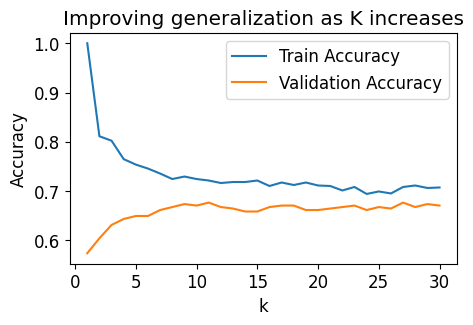

The number of neighbors (k) significantly affects model complexity
Increasing k generally improves generalization (reduces overfitting) up to a point


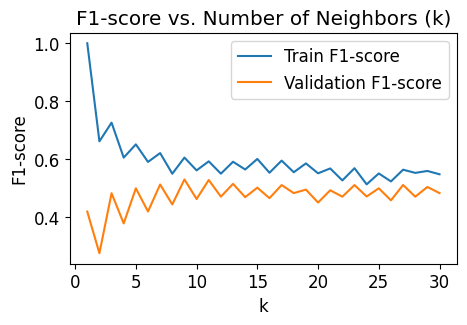

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

train_scores = []
Validation_scores = []
train_f1_scores = []
validation_f1_scores = []

k_values = range(1, 31)
for k in k_values:
    knn_model = make_pipeline(full_prep, KNeighborsClassifier(n_neighbors=k))

    knn_model.fit(X_train, y_train) #Train the model by training set

    # Make predictions
    y_train_pred = knn_model.predict(X_train)
    y_val_pred = knn_model.predict(X_val)

    # Calculate accuracy scores
    train_scores.append(accuracy_score(y_train, y_train_pred))
    Validation_scores.append(accuracy_score(y_val, y_val_pred))

    # Calculate F1 scores
    train_f1_scores.append(f1_score(y_train, y_train_pred))
    validation_f1_scores.append(f1_score(y_val, y_val_pred))
print ('Compare the accuracy between training and validation in each K')
plt.figure(figsize=(5,3 ))
plt.plot(k_values, train_scores, label="Train Accuracy")
plt.plot(k_values,Validation_scores, label="Validation Accuracy")
plt.title('Improving generalization as K increases')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print ('The number of neighbors (k) significantly affects model complexity')
print('Increasing k generally improves generalization (reduces overfitting) up to a point')
plt.figure(figsize=(5,3 ))
plt.plot(k_values, train_f1_scores, label="Train F1-score")
plt.plot(k_values, validation_f1_scores, label="Validation F1-score")
plt.title("F1-score vs. Number of Neighbors (k)")
plt.xlabel("k")
plt.ylabel("F1-score")
plt.legend()
plt.show()

#### For **small k** values, the model **overfits**, achieving perfect or near-perfect training accuracy but significantly lower validation performance.
#### As **k increases**, training and validation performance converge, indicating **improved generalization**.
#### **Moderate k** values provide the **best balance** between bias and variance.


---



# **B- Tune Hyperparameter** :  
> - ## **GridSearchCV** for kNN (Tune n_neighbors and weights)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(1, 31)),
    'kneighborsclassifier__weights': ['uniform', 'distance']
}
# Use GridSearchCV to find the best parameter 'k' using the training+validation data
grid_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='f1', n_jobs=-1) # Use F1 score because of the slight class imbalance

grid_knn.fit(X_train, y_train)

print("Best parameters found:", grid_knn.best_params_)  # The specific combination of hyperparameters that achieved the highest F1 score.
print(f"\nBest cross-validation F1 score: {grid_knn.best_score_:.2f}")  # The mean cross-validated score (F1) of the best parameter set.

best_knn = grid_knn.best_estimator_

Best parameters found: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__weights': 'uniform'}

Best cross-validation F1 score: 0.53


> - ## **Evaluate Tuned K Neighbors Model**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_val_pred_tuned_knn = best_knn.predict(X_val)

print("TUNED KNN Model Performance on Validation Set")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned_knn):.2f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred_tuned_knn):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_tuned_knn))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_tuned_knn, target_names=['0-not onSchedule', '1-onSchedule']))

TUNED KNN Model Performance on Validation Set
Validation Accuracy: 0.67
Validation F1: 0.53

Confusion Matrix:
 [[162  46]
 [ 62  61]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.72      0.78      0.75       208
    1-onSchedule       0.57      0.50      0.53       123

        accuracy                           0.67       331
       macro avg       0.65      0.64      0.64       331
    weighted avg       0.67      0.67      0.67       331



## **Tuned K Neighbors Model Performance Report**
###GridSearchCV identified an optimal neighborhood size that improved minority-class F1-score (best parameters: `n_neighbors=9`, `weights='uniform'`)
#### Hyperparameter tuning for the KNN model led to a **modest improvement** in overall accuracy and F1-score for the minority class. The model shows a better balance in precision and recall, but addressing the false negatives for the 'onSchedule' class remains a key area for further optimization.

# **2- Logistic Regression Model**

In [80]:
from sklearn.linear_model import LogisticRegression

baseline_logReg = Pipeline([
    ("prep", full_prep),                                    #liblinear: supports L1 (Lasso) regularization, which automatically perform feature selection.
    ("LogRegClf", LogisticRegression( solver="liblinear"))  # stable for small/medium data
])

baseline_logReg


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration',
                                                   'LangTestPercent',
                                                   'MathTestPercent',
                                                   'AptitudeTestPercent',
                                                   'transfer_in',
                                                   'Business101Grade',
                                                   'Mature']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['program', 'status',
                                                   'gender',
                                                   'Math101Grade'])])),
                ('LogRegClf', LogisticRegression(solver='liblinear'))])

## **A- Train and Evaluate Performance**
> - ### **Evaluate Baseline Model**

In [81]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

baseline_logReg.fit(X_train, y_train)   #Train the model

y_val_pred = baseline_logReg.predict(X_val)

print("Baseline Logistic Regression Model")
print("Validation Accuracy:", f"{accuracy_score(y_val, y_val_pred):.2f}")
print("Validation F1      :", f"{f1_score(y_val, y_val_pred):.2f}") # F1 = harmonic mean of precision and recall.
print("\nConfusion matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, target_names=['0-not onSchedule', '1-onSchedule']))


Baseline Logistic Regression Model
Validation Accuracy: 0.64
Validation F1      : 0.48

Confusion matrix:
 [[156  52]
 [ 68  55]]
                  precision    recall  f1-score   support

0-not onSchedule       0.70      0.75      0.72       208
    1-onSchedule       0.51      0.45      0.48       123

        accuracy                           0.64       331
       macro avg       0.61      0.60      0.60       331
    weighted avg       0.63      0.64      0.63       331



### **Model Performance Report** (before tuning)
####F1-score for class 1 (onSchedule) is the primary metric, Because classes are imbalanced.
### recall for class 1 is low -> The **model tends to favor the majority class**(0).
#### The model currently shows a **bias** toward the **majority class** ('not onSchedule'). Because the dataset is imbalanced, the model has learned the characteristics of class 0 more effectively than class 1, leading to a **high rate of False Negatives** for the 'onSchedule' category
####To **fix** this "Recall" **Problem**,  I add **class_weight='balanced'** inside LogisticRegression parameters (in GridSearch) -> This will tell the model to pay **more attention** to the **minority class**.

# **B- Hyperparameter tuning** using GridSearchCV

In [82]:
logReg_model = Pipeline([
    ("prep", full_prep),
    ("LogRegClf", LogisticRegression( max_iter=2000, solver="liblinear")) #2000:Maximum number of iterations allowed for convergence
])
param_grid = {
    "LogRegClf__C": np.logspace(-3, 3, 13),       # 0.001 ... 1000  controls model complexity
    "LogRegClf__penalty": ["l1", "l2"],           # Type of regularization
    "LogRegClf__class_weight": [None, "balanced"] # adjusts the importance of minority-class errors
}

cv = StratifiedKFold(n_splits=5, shuffle=True) # preserve class proportions across folds

grid_logReg = GridSearchCV(
    logReg_model, param_grid=param_grid, scoring="f1", cv=cv, n_jobs=-1)

grid_logReg.fit(X_train_val, y_train_val)

print("Best params found:", grid_logReg.best_params_)
print(f"Best cross-validation F1 score:: {grid_logReg.best_score_:.2f}")

best_logReg = grid_logReg.best_estimator_


Best params found: {'LogRegClf__C': np.float64(0.1), 'LogRegClf__class_weight': 'balanced', 'LogRegClf__penalty': 'l1'}
Best cross-validation F1 score:: 0.62


> - ## **Evaluate Tuned  Logistic Regression Model**

In [83]:
y_val_pred_tuned_logReg = best_logReg.predict(X_val)

print("TUNED Logistic Regression Model Performance on Validation Set")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned_logReg):.2f}")
print(f"Validation F1: {f1_score(y_val, y_val_pred_tuned_logReg):.2f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred_tuned_logReg))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred_tuned_logReg, target_names=['0-not onSchedule', '1-onSchedule']))

TUNED Logistic Regression Model Performance on Validation Set
Validation Accuracy: 0.65
Validation F1: 0.61

Confusion Matrix:
 [[125  83]
 [ 33  90]]

Classification Report:
                   precision    recall  f1-score   support

0-not onSchedule       0.79      0.60      0.68       208
    1-onSchedule       0.52      0.73      0.61       123

        accuracy                           0.65       331
       macro avg       0.66      0.67      0.65       331
    weighted avg       0.69      0.65      0.66       331



### Tuned Logistic Regression Model Performance Report

The Logistic Regression model, after hyperparameter tuning using `GridSearchCV` (best parameters: `C=0.1`, `class_weight='balanced'`, `penalty='l1'`), was evaluated on the validation set. The performance metrics are as follows:

*   **Validation Accuracy**: 0.65 (65%)
*   **Validation F1-score**: 0.61
*   **Confusion Matrix**:
    ```
    [[125  83]
     [ 33  90]]
    ```
    *   **True Negatives (TN)**: 125 (Correctly predicted 'not on schedule')
    *   **False Positives (FP)**: 83 (Incorrectly predicted 'on schedule')
    *   **False Negatives (FN)**: 33 (Incorrectly predicted 'not on schedule' when actually 'on schedule')
    *   **True Positives (TP)**: 90 (Correctly predicted 'on schedule')

#### Key Insights & Comparison to Baseline Logistic Regression:

1.  **Improved F1-score for 'onSchedule' class**: The F1-score for the 'onSchedule' class (Class 1) significantly improved from 0.48 (baseline) to 0.61 (tuned). This indicates a much better balance between precision and recall for the minority class.
2.  **Shift in Recall/Precision Trade-off**: The most notable improvement is in **Recall** for the 'onSchedule' class, which increased from 0.45 (baseline) to 0.73 (tuned). This means the tuned model is much better at identifying actual 'onSchedule' students. However, this came with a slight decrease in precision for the 'onSchedule' class (from 0.51 to 0.52), and a larger decrease in precision for the 'not onSchedule' class (0.79 vs 0.70 baseline).
3.  **Reduced False Negatives**: The number of False Negatives dramatically decreased from 68 (baseline) to 33. This is a critical improvement, as the model now misses fewer students who are actually 'on schedule'.
4.  **Increased False Positives**: Correspondingly, the number of False Positives increased from 52 (baseline) to 83. This means the model now incorrectly predicts more students as 'on schedule' when they are not.
5.  **Accuracy remained similar**: The overall validation accuracy remained similar (0.64 baseline vs 0.65 tuned). This highlights why F1-score and the classification report are more informative, especially when addressing class imbalance.

**Conclusion**: The hyperparameter tuning, especially with `class_weight='balanced'`, successfully addressed the baseline Logistic Regression model's bias towards the majority class. It significantly improved the model's ability to identify the minority class ('onSchedule'), leading to a higher F1-score and substantially fewer false negatives. While this resulted in more false positives, the overall performance for the critical 'onSchedule' class is much stronger, making this a more effective model for predicting students on schedule.

## **Tuned Logistic Regression Model Performance Report**
### Best parameters: `C=0.1`, `class_weight='balanced'`, `penalty='l1'`
### The hyperparameter tuning, especially with class_weight='balanced', **successfully addressed** the baseline Logistic Regression model's **bias** towards the **majority class**. It significantly improved the model's ability to identify the minority class ('onSchedule'), leading to a **higher F1-score** and substantially **fewer false negatives**. While this resulted in more false positives, the overall performance for the critical 'onSchedule' class is much stronger, making this a more effective model for predicting students on schedule.


# **3- SVN Model**

# **Final Comparison** (Test Set)

In [ ]:
best_knn.fit(X_train_val, y_train_val)
best_logReg.fit(X_train_val, y_train_val)
best_svm.fit(X_train_val, y_train_val)

In [ ]:
#Final Evaluation on Test Set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_pred = best_logReg.predict(X_test)

y_test_pred = best_knn.predict(X_test)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(grid_knn, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix: Predicted vs Actual')
plt.show()

NameError: name 'grid_knn' is not defined